# Soluciones a la Ecuación de Laplace con el método de Elementos Finitos

En la práctica, la forma de resolver la ecuación de Laplace (y/o Poisson) para sistemas de conductores que no presentan una simetría suficiente, en forma numérica, se basa en los métodos llamados de "Elementos Finitos".

En esta notebook, podemos jugar con las soluciones que estudiamos analíticamente y comparar los resultados con el método de elementos finitos mediante la librería "sfepy".

El procedimiento involucra varios pasos:
* Definición de una "malla": Implica elegir un espaciado adecuado, así como una discretización inteligente del dominio donde queremos calcular el potencial.
* Definición de las condiciones de frontera.
* Integración numérica de las ecuaciones.


# Construcción de la malla

En esta sección, definimos la malla y el valor del potencial sobre el borde. Podemos jugar con esta parte... 

In [454]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sfepy.discrete.fem.utils as fmeutils
from sfepy.discrete.fem import Mesh, FEDomain, Field

In [455]:
# Parámetros
n=51
orientacion = "x"
lado = 3.5

def caracteristica_triangulo_equilatero(coor):
    x = .5*np.abs(coor[0])
    y = .5*coor[1] + 1/np.sqrt(12.)
    if y < 0:
        return False
    return y <= np.sqrt(.75)*(1-2 * x)
    
    

def caracteristica_disco(coor):
    return (coor[0]**2 + coor[1]**2 < 1)


#funcion_caracteristica = caracteristica_disco
funcion_caracteristica = caracteristica_triangulo_equilatero


# Potencial fijo sobre el lado horizontal del triángulo
if funcion_caracteristica == caracteristica_triangulo_equilatero:
    def set_electric_bc(coor):
        ys = coor[:,1]
        val = np.array([ 10 if y< -1/np.sqrt(12)+.05 else 0 for y in ys ])
        return val
else:
    def set_electric_bc(coor):
        ys = coor[:,1]
        val = np.array([ 10 if y< 0 else -10 for y in ys ])
        return val


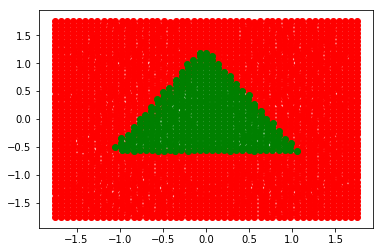

In [456]:
#Malla rectangular con disco

vertex = [np.array((x + .5*(np.random.rand()-.5)/n, y + .5*(np.random.rand()-.5)/n)) 
          for x in np.linspace(-lado/2,lado/2,n) for y in np.linspace(-lado/2,lado/2.,n) ]

if orientacion == "x":
    rects = np.array([[n*j+i,n*(j+1)+i,n*j+i+1] for i in range(n-1) for j in range(n-1)] + 
                 [[n*(j+1)+i,n*(j+1)+i+1,n*(j)+i+1] for i in range(n-1) for j in range(n-1)])
else:
    rects = np.array([[n*j+i,n*j+i+n+1,n*j+i+1] for i in range(n-1) for j in range(n-1)] + 
                 [[n*j+i,n*(j+1)+i,n*(j+1)+i+1] for i in range(n-1) for j in range(n-1)])
    
mat_ids = [np.array([2 if funcion_caracteristica(vertex[b[0]]) else 1  for b in rects])]
#mat_ids = [np.array([1  for b in rects])]
ngroups = [2 if  funcion_caracteristica(v) else 1 for v in vertex]
mesh=Mesh.from_data("poligono", vertex, ngroups, [rects],mat_ids,["2_3"])
domain = FEDomain('domain', mesh)
#domain = domain.refine()
#domain = domain.refine()
domain.create_region(name="g1",select="cells of group 1")
domain.create_region(name="g2",select="cells of group 2")
domain.create_region("S0","r.g1 *v r.g2","facet")
domain.create_region("Sext","vertices of surface","facet")

mesh=Mesh(cmesh=domain.cmesh)
mesh.write("mimesh.mesh")
coors=domain.get_mesh_coors()
r1=domain.regions[0]
r2=domain.regions[1]
r0=domain.regions[2]
rext=domain.regions[3]
coors1=  np.array([coors[i] for i in r1.vertices])
coors2=  np.array([coors[i] for i in r2.vertices])
coors3=  np.array([coors[i] for i in r0.vertices])
coors4=  np.array([coors[i] for i in rext.vertices])

plt.scatter(coors1[:,0],coors1[:,1],c="r")
plt.scatter(coors2[:,0],coors2[:,1],c="g")
#plt.scatter(coors3[:,0],coors3[:,1],c="b")
#plt.scatter(coors4[:,0],coors4[:,1],c="c")

# Solución de Laplace

## Definición del problema

En este punto, debemos definir el problema a resolver. Usaremos el archivo "mimesh.mesh" donde guardamos la malla que generamos.

In [457]:
import sys
import os
import numpy as np
from sfepy import data_dir

filename_mesh = os.getcwd() + "/" +'mimesh.mesh'
conductivity = 1.


# Tiempo inicial, final y paso para problema de difusión
t0 = 0.0
t1 = 0.5
n_step = 11





problem_definition = {
    'filename_mesh': filename_mesh,
    'options' : {
        'absolute_mesh_path' : True,
        'output_dir' : os.path.join(os.getcwd(), 'output')
    },
    'regions' : {
        'Omega' : 'all',
        'Omega1' : ('cells of group 1'),
        'Omega2' : ('cells of group 2'),
        'Omega2_Surface': ('r.Omega1 *v r.Omega2', 'facet'),
        'Omega_Surface':("vertices of surface",'facet'),
    },
    # Parámetros volumétricos (coeficientes de la ec. diferencial)
    'materials' : {
        'm' : ({
            'thermal_conductivity' : 2.0,
            'electric_conductivity' : 1.5,
        },),
    },
# The fields use the same approximation, so a single field could be used
# instead.
    'fields' : {
        'potential' : ('real', 1, 'Omega', 1),
    },
    # Variables en términos de las cuales se describen los campos
    'variables' : {
        'phi' : ('unknown field', 'potential', 1),
        'psi' : ('test field', 'potential', 'phi'),
        'phi_known' : ('parameter field', 'potential', '(set-to-None)'),
    },
    # Condiciones Iniciales (para problemas dependientes del tiempo)
    'ics' : {
        'ic' : ('Omega', {'T.0' : 0.0}),
    },
    # Condiciones de borde intrínsecas (Dirichlet)
    'ebcs' : {
        #'left' : ('Left', {'T.0' : 0.0, 'phi.0' : 0.0}),
        #'right' : ('Right', {'T.0' : 2.0, 'phi.0' : 0.0}),
        'inside' : ('Omega2_Surface', {'phi.0' : 'set_electric_bc'}),
        'outside' : ('Omega_Surface',{'phi.0': 0.})
    },
    # Funciones definidas en python para fijar condiciones de borde no constantes
    'functions' : {
        'set_electric_bc' : (lambda ts, coor, bc, problem, **kwargs:
                         set_electric_bc(coor),),
    },
    # Ecuaciones: 1-> Ecuación de Laplace 2-> Ec. de difusión
    'equations' : {
        '1' : """dw_laplace.2.Omega( m.electric_conductivity, psi, phi ) = 0""",
     },
    # Solvers: método que utiliza para resolver las ecuaciones
    'solvers': {
       'ls' : ('ls.scipy_direct', {}),
       'newton' : ('nls.newton', {
        'i_max'      : 1,
        'eps_a'      : 1e-10,
        'problem'   : 'nonlinear',
    }),
    # Tiempos para la evolución del problema dinámico (No la usaremos)
    'ts' : ('ts.simple', {
        't0'     : t0,
        't1'     : t1,
        'dt'     : None,
        'n_step' : n_step, # has precedence over dt!
        'verbose' : 0,
    }),
}
}

In [458]:
from sfepy.base.base import output
from sfepy.base.conf import ProblemConf, get_standard_keywords
from sfepy.discrete import Problem

output.prefix = ''

required, other = get_standard_keywords()
conf = ProblemConf.from_dict(problem_definition, None, other=other)

problem = Problem.from_conf(conf, init_equations=False)

# Setup output directory according to options above.
problem.setup_default_output()

# First solve the stationary electric conduction problem.
problem.set_equations({'eq' : conf.equations['1']})
state_el = problem.solve(verbose=False)
problem.save_state(problem.get_output_name(suffix = 'el'), state_el)

# Then solve the evolutionary heat conduction problem, using state_el.
#problem.set_equations({'eq' : conf.equations['2']})
#phi_var = problem.get_variables()['phi_known']
#phi_var.set_data(state_el())
#problem.solve()

#output('results saved in %s' % problem.get_output_name(suffix = '*'))


  left over: ['filename_mesh', 'regions', 'materials', 'fields', 'variables', 'ebcs', 'equations', 'solvers', 'verbose', '_filename']
  reading mesh [line2, tri3, quad4, tetra4, hexa8] (/home/mauricio/Dropbox/A - investigacion/jupyter-notebooks/electro/mimesh.mesh)...
  ...done in 0.01 s
  creating regions...
      Omega
      Omega1
      Omega2
      Omega_Surface
      Omega2_Surface
  ...done in 0.01 s
  using solvers:
                ts: ts
               nls: newton
                ls: ls
  equation "eq":
  dw_laplace.2.Omega( m.electric_conductivity, psi, phi ) = 0
  updating variables...
  ...done
  setting up dof connectivities...
  ...done in 0.00 s
  matrix shape: (2274, 2274)
  assembling matrix graph...
  ...done in 0.00 s
  matrix structural nonzeros: 15170 (2.93e-03% fill)
  updating materials...
      m
  ...done in 0.00 s
  updating variables...
  ...done
  updating materials...
      m
  ...done in 0.00 s
  updating variables...
  ...done
  updating materials...
     

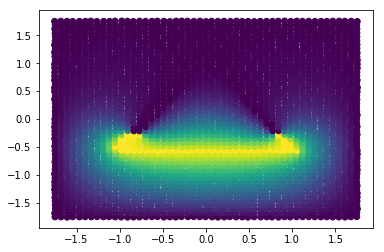

In [459]:
%matplotlib inline
import matplotlib.pyplot as plt

coords = problem.get_mesh_coors()
phi = problem.get_variables().get_state_parts()["phi"]
plt.scatter(coords[:,0], coords[:,1], c=phi)
